## Preparing Radiomics Data

In [1]:
import glob
import os

# data folders relative to repo
base_folders = [
    "../20241221_074106",
    "../20241223_164057",
    "../20250104_064120",
    "../20250105_082554"
]

json_paths = []

for base in base_folders:
    inner = os.path.basename(base)
    search_pattern = os.path.join(base, inner, "LIDC-IDRI", "LIDC-IDRI-*", "*", "*", "*.json")
    found = glob.glob(search_pattern)
    json_paths.extend(found)

print(f" Total JSON files collected: {len(json_paths)}")
if json_paths:
    print("Example:", json_paths[0])


 Total JSON files collected: 1487
Example: ../20241221_074106\20241221_074106\LIDC-IDRI\LIDC-IDRI-0000\01-01-2000-NA-NA-02587\3976134.000000-NA-94964\segmentation_00000.json


In [2]:
benign = [
    "Granuloma", "Active Infection", "Sarcoidosis", "Hamartoma",
    "Bronchioloalveolar Hyperplasia", "Long Covid", "Intrapulmonary Lymph Nodes"
]

malignant = [
    "Adenocarcinoma", "Squamous Cell Carcinoma", "Large Cell (Undifferentiated) Carcinoma",
    "Small Cell Lung Cancer (SCLC)", "Carcinoid Tumors", "Sarcomatoid Carcinoma",
    "Lymphoma", "Adenoid Cystic Carcinoma", "Metastatic Tumors"
]

def classify_nodule_type(name):
    if name in benign:
        return "Benign"
    elif name in malignant:
        return "Malignant"
    else:
        return "Unknown"  


In [3]:
import json
import pandas as pd

all_data = []

for file in json_paths:
    with open(file, "r") as f:
        data = json.load(f)

    characteristics = data.get("characteristics", [])
    slice_thickness = data.get("slice_thickness", None)
    annotations = data.get("annotation", [])

    slice_numbers = []
    for ann in annotations:
        if isinstance(ann, dict):
            slice_numbers.extend(map(int, ann.keys()))
    slice_numbers = sorted(set(slice_numbers))  # remove duplicates + sort


    for char in characteristics:
        nodule_name = char.get("nodule_name")
        row = {
            "nodule_name": nodule_name,
            "nodule_category": classify_nodule_type(nodule_name),
            "calcification": char.get("calcification"),
            "internal_structure": char.get("internal_structure"),
            "lobulation": char.get("lobulation"),
            "margin": char.get("margin"),
            "nodule_type": char.get("nodule_type"),
            "sphericity": char.get("sphericity"),
            "texture": char.get("texture"),
            "global_seed": char.get("global_seed"),
            "slice_thickness": slice_thickness,
            "slices_present": slice_numbers,
            "file_path": file
        }
        all_data.append(row)

df = pd.DataFrame(all_data)

Some nodules as named as "Hyperplasia" instead of "Bronchioloalveolar Hyperplasia"

In [4]:
df["nodule_name"] = df["nodule_name"].replace("Hyperplasia", "Bronchioloalveolar Hyperplasia")

Some nodules are named "Granuloma - Active Infection". Renaming it to just "Active Infection"

In [5]:
df["nodule_name"] = df["nodule_name"].replace("Granuloma - Active Infection", "Active Infection")

Since both of them are benign nodules, replace their category from "Unknown" to "Benign"

In [6]:
df["nodule_category"] = df["nodule_category"].replace("Unknown", "Benign")

In [7]:
df[:5]

,nodule_name,nodule_category,calcification,internal_structure,lobulation,margin,nodule_type,sphericity,texture,global_seed,slice_thickness,slices_present,file_path
0,Small Cell Lung Cancer (SCLC),Malignant,Absent,Soft Tissue,Nn-Mk,P-Sharp,m4,Lin-Ov,NS-PS,3388.5178,2.00,"[53, 54, 55, 56, 57]",../20241221_074106\20241221_074106\LIDC-IDRI\L...
1,Lymphoma,Malignant,Absent,Soft Tissue,N-Marked,Poo-Sh,m7,Ovoid,Part Solid/Mixed,9335.7762,2.00,"[70, 71, 72, 73, 74, 75]",../20241221_074106\20241221_074106\LIDC-IDRI\L...
2,Bronchioloalveolar Hyperplasia,Benign,Absent,Soft Tissue,Nn-Mk,Poorly,b6,Linear,NS-PS,9151.7012,2.50,"[26, 27, 28]",../20241221_074106\20241221_074106\LIDC-IDRI\L...
3,Carcinoid Tumors,Malignant,Non-Central,Soft Tissue,None,P-Sharp,m5,Ov-Ro,Solid,201.8990,2.50,"[51, 52, 53]",../20241221_074106\20241221_074106\LIDC-IDRI\L...
4,Intrapulmonary Lymph Nodes,Benign,Absent,Soft Tissue,None,Sharp,b7,Ovoid,Solid,8747.3172,1.25,"[23, 24, 25, 26, 27]",../20241221_074106\20241221_074106\LIDC-IDRI\L...


## Exploratory Data Analysis

In [8]:
print("Total nodules:", len(df))

Total nodules: 1487


In [9]:
from collections import defaultdict

grouped_counts = defaultdict(list)

name_counts = df["nodule_name"].value_counts()

for name, count in name_counts.items():
    category = classify_nodule_type(name)
    grouped_counts[category].append((name, count))

for category in ["Benign", "Malignant", "Unknown"]:
    if grouped_counts[category]:
        print(f"\n{category}:")
        for i, (name, count) in enumerate(grouped_counts[category], 1):
            print(f"{i}. {name} - {count}")


Benign:
1. Bronchioloalveolar Hyperplasia - 192
2. Granuloma - 153
3. Sarcoidosis - 96
4. Active Infection - 94
5. Hamartoma - 82
6. Intrapulmonary Lymph Nodes - 67

Malignant:
1. Adenoid Cystic Carcinoma - 105
2. Small Cell Lung Cancer (SCLC) - 93
3. Lymphoma - 93
4. Carcinoid Tumors - 91
5. Large Cell (Undifferentiated) Carcinoma - 90
6. Metastatic Tumors - 88
7. Squamous Cell Carcinoma - 83
8. Sarcomatoid Carcinoma - 81
9. Adenocarcinoma - 79


NOTE: Long Covid is not relevant to our study, hence it is not present in our dataset

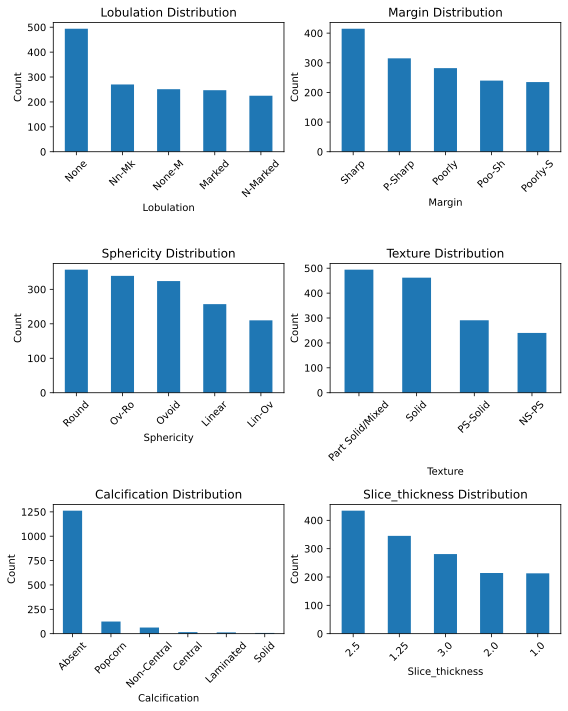

In [10]:
import matplotlib.pyplot as plt

features = ["lobulation", "margin", "sphericity", "texture", "calcification", "slice_thickness"]

fig, axes = plt.subplots(3, 2, figsize=(8, 10))
axes = axes.flatten()  

for i, feature in enumerate(features):
    df[feature].value_counts().plot(kind='bar', ax=axes[i])
    axes[i].set_title(f"{feature.capitalize()} Distribution")
    axes[i].set_xlabel(feature.capitalize())
    axes[i].set_ylabel("Count")
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.subplots_adjust(wspace=0.2)
plt.show()

What do these x-axis values mean??

In [11]:
from pprint import pprint

feature_counts = {}

for feature in features:
    counts = df[feature].value_counts().to_dict()
    feature_counts[feature] = counts

pprint(feature_counts)

{'calcification': {'Absent': 1262,
                   'Central': 16,
                   'Laminated': 13,
                   'Non-Central': 63,
                   'Popcorn': 125,
                   'Solid': 8},
 'lobulation': {'Marked': 247,
                'N-Marked': 225,
                'Nn-Mk': 270,
                'None': 494,
                'None-M': 251},
 'margin': {'P-Sharp': 315,
            'Poo-Sh': 240,
            'Poorly': 282,
            'Poorly-S': 235,
            'Sharp': 415},
 'slice_thickness': {1.0: 213, 1.25: 345, 2.0: 214, 2.5: 434, 3.0: 281},
 'sphericity': {'Lin-Ov': 210,
                'Linear': 257,
                'Ov-Ro': 339,
                'Ovoid': 324,
                'Round': 357},
 'texture': {'NS-PS': 240,
             'PS-Solid': 291,
             'Part Solid/Mixed': 494,
             'Solid': 462}}


In [12]:
df["internal_structure"].value_counts()

internal_structure
Soft Tissue    1487
Name: count, dtype: int64

## Creating a 17th class - Normal

In [13]:
total_slice_count = df["slices_present"].apply(len).sum()
print(f" Total number of slices in dataset: {total_slice_count}")

 Total number of slices in dataset: 6779


In [14]:
average_slice_count = df["slices_present"].apply(len).mean()
print(f" Average number of slices per row: {average_slice_count:.2f}")

 Average number of slices per row: 4.56


Let's say I take 100 normal samples. Each with 4 slices each = total 400 slices more.  
This approach helps us analyze slices in 2D or look at the 3D space also.

In [15]:
import os
import pydicom

n = 100
CONSECUTIVE = 4
normal_rows = []

sampled = df.sample(n, random_state=42)

for i, row in sampled.iterrows():
    slices = row["slices_present"]
    if not slices or len(slices) < 1:
        continue

    scan_folder = os.path.dirname(row["file_path"])
    dicom_files = [f for f in os.listdir(scan_folder) if f.endswith('.dcm')]

    instance_numbers = []
    for f in dicom_files:
        try:
            dcm = pydicom.dcmread(os.path.join(scan_folder, f), stop_before_pixels=True)
            instance = int(dcm.InstanceNumber)
            instance_numbers.append(instance)
        except:
            continue

    if not instance_numbers:
        continue

    instance_numbers = sorted(instance_numbers)
    max_available = max(instance_numbers)
    min_available = min(instance_numbers)

    # Core logic
    after_possible = slices[-1] + CONSECUTIVE <= max_available and slices[-1] <= max_available - 5
    before_possible = slices[0] - CONSECUTIVE >= min_available and slices[0] >= min_available + 5

    if after_possible:
        chosen = list(range(slices[-1] + 1, slices[-1] + 1 + CONSECUTIVE))
        direction = "after"
    elif before_possible:
        chosen = list(range(slices[0] - CONSECUTIVE, slices[0]))
        direction = "before"
    else:
        print(f" Row {i}: Too close to scan boundary, skipping.")
        continue


    normal_rows.append({
                "nodule_name": "No nodule",
                "nodule_category": "Normal",
                "calcification": None,
                "internal_structure": None,
                "lobulation": None,
                "margin": None,
                "nodule_type": None,
                "sphericity": None,
                "texture": None,
                "global_seed": None,
                "slice_thickness": row.get("slice_thickness", None),
                "slices_present": chosen,
                "file_path": scan_folder
            })


In [16]:
normal_df = pd.DataFrame(normal_rows)
df = pd.concat([df, normal_df], ignore_index=True)

In [17]:
df["nodule_category"].value_counts()

nodule_category
Malignant    803
Benign       684
Normal        97
Name: count, dtype: int64

In [19]:
df.to_csv("training_data.csv", index=False)

Now we have approximately 1600 samples